# Modelling and Evaluation

### Inputs
- Train set engineered CSV

### Outputs

### Objectives

- Select best hyperparameters and algorithm
- Predict CSmpA of concrete via regression

In [1]:
import os
current_dir = os.getcwd()
current_dir


'/workspace/concrete-strength/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/concrete-strength'

Load data

In [14]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/cleaned/DatasetEngineered.csv"))
print(df.shape)
df.head()

(1030, 8)


,cement,slag,flyash,water,coarseaggregate,fineaggregate,age,csMPa
0,11.138686,0.692662,1.0,74.797774,2269.592565,83874.646831,3.377358,79.99
1,11.138686,0.692662,1.0,74.797774,2306.547918,83874.646831,3.377358,61.89
2,9.813326,4.948381,1.0,98.669830,2005.603189,66232.900982,5.630006,40.27
3,9.813326,4.948381,1.0,98.669830,2005.603189,66232.900982,5.933598,41.05
4,8.520842,4.876641,1.0,85.841906,2118.561303,120826.246384,5.919698,44.30


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(['csMPa'], axis=1), df['csMPa'], test_size = 0.20, random_state = 37)

In [17]:
X_train.dtypes
X_train.head()

,cement,slag,flyash,water,coarseaggregate,fineaggregate,age
328,9.106729,0.692662,0.010020,68.864920,2141.530685,138351.338204,4.634036
209,8.877286,0.692662,0.008382,87.108031,2243.518943,103536.132378,1.387998
291,8.313184,3.839427,0.008130,77.852517,2317.401100,109113.656387,3.377358
32,8.520842,4.876641,1.000000,85.841906,2118.561303,120826.246384,5.222505
792,9.940810,0.692662,1.000000,85.841906,2286.829875,115661.505742,5.919698


Create pipeline

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

def PipelineOptimization(model):
    pipeline_base = Pipeline([ ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model)])
    
    return pipeline_base

Hyperparameter optimisation search

In [19]:
from sklearn.model_selection import GridSearchCV

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))
            
            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

In [20]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [21]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [22]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
6,XGBRegressor,0.894199,0.911207,0.927696,0.013076
0,LinearRegression,0.755679,0.780126,0.798832,0.014315
5,GradientBoostingRegressor,0.649859,0.763181,0.838872,0.071774
4,AdaBoostRegressor,0.60591,0.709654,0.759523,0.055824
2,RandomForestRegressor,0.602454,0.664094,0.727387,0.041525
3,ExtraTreesRegressor,0.53379,0.610182,0.679237,0.047197
1,DecisionTreeRegressor,0.489564,0.54953,0.651809,0.065836


Extensive search on most suitable model - https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook

In [23]:
models_search = {
    "XGBRegressor": XGBRegressor(random_state=0)
}

params_search = {
    "XGBRegressor": {
        #'min_child_weight': [1, 5, 10],
        #'gamma': [0.5, 1, 1.5, 2, 5],
        #'subsample': [0.6, 0.8, 1.0],
        #'colsample_bytree': [0.6, 0.8, 1.0],
        #'max_depth': [3, 4, 5],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__n_estimators': [100, 500, 1000]
    }
}

In [25]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [26]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__n_estimators
7,XGBRegressor,0.899619,0.916563,0.930889,0.012,0.1,500
8,XGBRegressor,0.899363,0.916459,0.930375,0.011825,0.1,1000
5,XGBRegressor,0.896418,0.912947,0.929101,0.01223,0.05,1000
4,XGBRegressor,0.897797,0.912331,0.929615,0.012284,0.05,500
6,XGBRegressor,0.895844,0.908717,0.925709,0.011599,0.1,100
2,XGBRegressor,0.892552,0.906929,0.925345,0.012157,0.01,1000
3,XGBRegressor,0.879779,0.892973,0.910943,0.011494,0.05,100
1,XGBRegressor,0.878416,0.892863,0.910824,0.011592,0.01,500
0,XGBRegressor,0.026985,0.046721,0.079861,0.01814,0.01,100


Best params for mean R2 Score

In [27]:
params_search = {'XGBRegressor': {
    'model__learning_rate': [0.1],
    'model__n_estimators': [500]
}}

Fit model with best parameters

In [28]:
xgbr = XGBRegressor(learning_rate=0.05, n_estimators=1000, verbosity=1)
pipeline_xgbr = PipelineOptimization(xgbr)

In [29]:
pipeline_xgbr.fit(X_train, y_train)

Pipeline(steps=[('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=XGBRegressor(base_score=0.5,
                                                        booster='gbtree',
                                                        callbacks=None,
                                                        colsample_bylevel=1,
                                                        colsample_bynode=1,
                                                        colsample_bytree=1,
                                                        early_stopping_rounds=None,
                                                        enable_categorical=False,
                                                        eval_metric=None,
                                                        feature_types=None,
                                                        gamma=0, gpu_id=-1,
                                                        grow_policy='depth

In [31]:
score = pipeline_xgbr.score(X_train, y_train)
print("Training score: ", score)

Training score:  0.9932028222325382


5-Fold and K-Fold Cross validation

In [33]:
from sklearn.model_selection import cross_val_score, KFold
scores = cross_val_score(pipeline_xgbr, X_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(pipeline_xgbr, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

Mean cross-validation score: 0.88
K-fold CV average score: 0.92


NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [26]:
test_target

0      26.06
1      10.35
2      79.30
3      74.99
4       9.69
       ...  
201    27.53
202    33.76
203    33.01
204    33.72
205    13.82
Name: csMPa, Length: 206, dtype: float64

In [35]:
pipeline_xgbr.predict(X_test)

array([39.791874 , 28.880054 , 46.753452 , 38.49021  , 46.14561  ,
       33.908855 , 37.72208  , 54.1251   , 27.770594 , 25.527077 ,
       62.335064 , 42.56269  , 38.052025 , 16.772724 , 32.193142 ,
       44.659138 , 10.814329 , 28.71086  , 37.672127 , 20.747593 ,
       66.25688  ,  6.8244557, 61.47373  , 46.70098  , 23.686335 ,
       79.2818   , 61.99543  , 22.921988 , 43.545197 , 50.146194 ,
       37.12577  , 24.102062 , 14.115099 , 30.456453 , 16.498222 ,
       42.68169  , 13.761599 , 31.832699 , 33.52483  , 55.26794  ,
       12.436802 , 32.61577  , 25.234888 ,  2.272539 , 36.76353  ,
       12.223426 , 35.273903 , 56.73928  , 39.48408  , 18.798868 ,
       34.034653 , 40.00967  , 43.238167 , 43.89158  , 15.036641 ,
       48.46349  , 65.007095 , 53.630173 , 40.855854 , 55.01884  ,
       13.363162 , 35.097366 , 17.675898 , 35.470146 , 21.089275 ,
       31.755848 , 13.780099 , 27.944054 , 38.176315 , 44.786762 ,
       42.143806 , 30.891882 , 51.463623 , 40.861526 , 56.3494

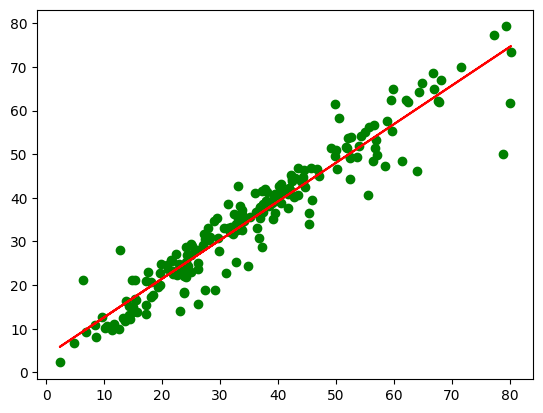

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(y_test, pipeline_xgbr.predict(X_test), 'o', color='green')
m, b = np.polyfit(y_test, pipeline_xgbr.predict(X_test), 1)
plt.plot(y_test, m*y_test+b, color='red')

In [39]:
from sklearn import metrics
metrics.r2_score(y_test, pipeline_xgbr.predict(X_test))

0.9085554734316416

In [9]:
import joblib
import os
version = 'v1'
file_path = f'outputs/ml_pipeline/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/v1'


In [17]:

joblib.dump(value=pipeline_xgbr, 
filename=f'{file_path}/regression_model.pkl')

['outputs/ml_pipeline/v1/regression_model.pkl']

In [16]:
import pickle
PFILE = f'{file_path}/regression_model.pkl'
def read_from_pickle(p):
      with open(p, 'rb') as f:
        yield pickle.load(f)


In [18]:
regressor_model = read_from_pickle(PFILE)

In [19]:
regressor_model.predict(test_features)

AttributeError: 'generator' object has no attribute 'predict'